<a href="https://colab.research.google.com/github/agreshg07/Neural_Networks/blob/main/IntelligentSystems_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import seaborn as sn
import random as rd
import pickle

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Create dataset file splits for Train, Test and Challenge steps from the overall MNIST dataset

*Run only once!*

In [3]:
""" Read input data from files """
""" Combine the labels and image pixel data into one DF """
df_MNIST = pd.read_csv('MNISTnumImages5000_balanced.txt', delimiter='\t', header=None)
df_MNIST_label = pd.read_csv('MNISTnumLabels5000_balanced.txt', delimiter='\t', header=None)
df_MNIST['Labels'] = df_MNIST_label
df_MNIST.iloc[:,:-1] = ((df_MNIST.iloc[:,:-1] - df_MNIST.iloc[:,:-1].mean())/df_MNIST.iloc[:,:-1].std(ddof=0)).fillna(0)
display(df_MNIST)

""" Create individual files for each label (500 images each) """
dataset = {}
for i in range (10):
  dataset[i] = df_MNIST[i*500:(i+1)*500]

""" Split the data for 0s and 1s into TRAIN set (400 images each) """
df_MNIST_01 = pd.concat([dataset[0][:500], dataset[1][:500]], ignore_index= True)
df_MNIST_01 = df_MNIST_01.sample(frac=1).reset_index(drop=True)

""" Split into train and test sets """
df_MNIST = df_MNIST.sample(frac=1).reset_index(drop=True)
df_MNIST_Train = df_MNIST.iloc[:4000,:].reset_index(drop=True)
df_MNIST_Test = df_MNIST.iloc[4000:,:].reset_index(drop=True)

print(df_MNIST_Train.shape)
print(df_MNIST_Test.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,Labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016593,-0.026878,-0.039207,-0.032471,-0.026338,...,-0.030416,-0.022835,-0.026781,-0.027567,-0.020111,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014144,-0.020004,-0.014144,-0.020803,-0.018799,0.0,0.0,0.0,0.0,-0.014144,-0.022326,-0.021035,-0.014144,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.015918,-0.017173,-0.014144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

(4000, 785)
(1000, 785)


## Class for Neural Network Creation

In [26]:
class NeuralNetwork:
  inputs = int()
  outputs = int()
  hiddenlist = list()
  network = list()
  error_list = pd.DataFrame(columns=['epoch', 'Train_error', 'Test_error'])

  def __init__(self):
    self.network = []
  
  def saveNetwork(self, fileName, errorsave = True):
    if self.network:
      with open(fileName, 'wb') as dbfile1:
        pickle.dump(self.network, dbfile1, protocol=pickle.HIGHEST_PROTOCOL)
      
      if errorsave:
        errfile = fileName + '_errorList'
        with open(errfile, 'wb') as dbfile1:
          pickle.dump(self.error_list, dbfile1, protocol=pickle.HIGHEST_PROTOCOL)
      
      return 'Network saved as ' + fileName

    else:
      return 'No Network Exists. Initialize Neural Network First'

  def loadNetwork(self, fileName, errorload=True):
    if fileName:
      with open(fileName, 'rb') as dbfile:
        self.network = pickle.load(dbfile)
      
      if errorload:
        errfile = fileName + '_errorList'
        with open(errfile, 'rb') as dbfile:
          self.error_list = pickle.load(dbfile)

    else:
      return 'Please provide a filename'
    
  def create_NeuralNet(self, n_inputs, l_hiddenlayer, n_outputs):
    self.inputs = n_inputs
    self.outputs = n_outputs
    self.hiddenlist = l_hiddenlayer

    n_hiddenlayers = len(l_hiddenlayer)

    if self.network:
      print('Neural Network already exists. Reintantiate the object or create a new one!')
      return -1

    if n_hiddenlayers > 0:
      for i, N in enumerate(l_hiddenlayer):
        n_hiddenNeurons = N
        if n_hiddenNeurons > 0 and i==0:
          hidden_layer = [{
                            'weights':list(np.random.randint(-5,5,size=n_inputs + 1)/100)
                            ,'w_delta':list(np.zeros(n_inputs+1))
                          } for i in range(n_hiddenNeurons)]
          self.network.append(hidden_layer)
        elif n_hiddenNeurons > 0 and i > 0:
          n_prev_layer = l_hiddenlayer[i-1]
          hidden_layer = [{
                            'weights':list(np.random.randint(-5,5,size=n_prev_layer + 1)/100)
                            ,'w_delta':list(np.zeros(n_prev_layer+1))
                          } for i in range(n_hiddenNeurons)]
          self.network.append(hidden_layer)
    elif n_hiddenlayers == 0:
      n_hiddenNeurons = n_inputs
    output_layer = [{
                      'weights':list(np.random.randint(-5,5,size=n_hiddenNeurons + 1)/100)
                      ,'w_delta':list(np.zeros(n_hiddenNeurons+1))
                    } for i in range(n_outputs)]
    self.network.append(output_layer)

  
  def get_info(self):
    return self.inputs, self.hiddenlist, self.outputs
  
  def display_NeuralNet(self):
    for i,layer in enumerate(self.network):
      l_type = 'Hidden Layer'
      if i > len(self.hiddenlist)-1:
        l_type = 'Output Layer'
      for j,neuron in enumerate(layer):
        w = len(neuron['weights'])
        d = len(neuron['w_delta'])
        # info = self.get_info()
        print(f'Type: {l_type} \t|\t Neuron: {i+1} {j+1} \t|\t weights: {w}')
      print('--------------------------------------------------------')
  
  def fireNeuralNetwork(self, dataRecord):
    X = dataRecord[:]
    for layer in self.network:
      output = []
      for neuron in layer:
        S = netInput(neuron['weights'], X)
        neuron['output'] = activationFunction(S)
        output.append(neuron['output'])
      X = output[:]
    return X

  def backpropagation(self, expected):
    for i in reversed(range(len(self.network))):
      layer = self.network[i]
      errors = list()
      if i != len(self.network)-1:
        for j in range(len(layer)):
          error = 0.0
          for neuron in self.network[i + 1]:
            error += (neuron['weights'][j] * neuron['delta'])
          errors.append(error)
      else:
        for j in range(len(layer)):
          neuron = layer[j]
          errors.append(neuron['output'] - expected[j])
      for j in range(len(layer)):
        neuron = layer[j]
        neuron['delta'] = errors[j] * dFdx(neuron['output'])
  
  # Update network weights with error
  def update_weights(self, row, eta, mtm=0.01):
    for i,layer in enumerate(self.network):
      inputs = np.append(np.array(row[:-1]),1)
      if i != 0:
        inputs = [neuron['output'] for neuron in self.network[i - 1]]
        inputs = np.append(np.array(inputs),1)
      for neuron in layer:
        momentum = mtm*np.array(neuron['w_delta'])
        neuron['w_delta']  = list(np.array(-1.0 * eta * neuron['delta'] * inputs) + momentum)
        neuron['weights'] = list(np.array(neuron['weights']) + np.array(neuron['w_delta']))
   
  def predictNN(self, dataRecord, unq_lb):
    output = self.fireNeuralNetwork(dataRecord)
    return decode_label(unq_lb, output)
  
  def trainNN(self, train_data, test_data, bFrac=0.2, epoch=100, eta=0.01, mtm=0.01, savePickle=False):
    bSize = len(train_data)*bFrac
    Network = []
    best_epoch = 0
    min_error = 100
    try:
      for e in range(epoch):
        batch = get_batch(train_data, bSize)
        classes = target_class(batch)
        error_sum = 0
        batch = np.array(batch)
        for row in batch:
          outputs = self.fireNeuralNetwork(row[:-1])
          error_sum += is_error(classes, row[-1], outputs)
          self.backpropagation(encode_label(classes, row[-1]))
          self.update_weights(row, eta, mtm)
        error_percent = error_sum*100.0/len(batch)
        if error_percent < min_error:
          best_epoch = e
          Network = self.network
          min_error = error_percent
        
        test_batch = get_batch(test_data, int(bSize//10))
        test_classes = target_class(test_batch)
        test_error_sum = 0
        test_batch = np.array(test_batch)
        for trow in test_batch:
          pred = self.fireNeuralNetwork(trow[:-1])
          test_error_sum += is_error(test_classes, trow[-1], pred)
        test_error_percent = test_error_sum*100.0/len(test_batch)
        self.error_list.loc[len(self.error_list.index)] = [e, error_percent, test_error_percent]
        if e%10==0:
          print('>epoch=%d, train error=%.3f, test error=%.3f, min err=%.3f' % (e, error_percent, test_error_percent, min_error))
    except KeyboardInterrupt:
      print(f'Best error of {min_error} found at epoch:{best_epoch}')
      
    finally:
      if savePickle:
        self.saveNetwork('HW4_NNet_FinalNetwork', True)
    return self.error_list, Network

## Helper functions

In [5]:
def netInput(weights, inputs):
	inputs = np.append(np.array(inputs),1)
	return np.dot(np.array(weights), inputs)

def activationFunction(S, type='sigmoid'):
  return 1.0 / (1.0 + exp(-S))

def dFdx(H, type='sigmoid'):
  return H * (1.0 - H)

def is_error(unq_lb, actual, pred):
  p = decode_label(unq_lb, pred)
  return 1 if actual!=p else 0

def target_class(data):
  if type(data) != type(pd.DataFrame()):
    data = pd.DataFrame(data)
  lb = data.iloc[:,-1]
  return list(set(lb))

def get_batch(dataset, size):
  labels = target_class(dataset)
  samplesize = int(size//len(labels))
  sample = pd.DataFrame()
  for label in labels:
    sample = sample.append(dataset[dataset.iloc[:,-1]==label].sample(samplesize).reset_index(drop=True))
  return sample

def encode_label(unq_labels, current_label):
  unq_labels.sort()
  encodedlabels = np.zeros(len(unq_labels), dtype=int)
  encodedlabels[unq_labels.index(current_label)] = 1
  return encodedlabels

def decode_label(unq_labels, encodedlabels):
  unq_labels.sort()
  current_label = unq_labels[list(encodedlabels).index(max(encodedlabels))]
  return current_label

## Visualization Functions

In [6]:
def generate_confusion_matrix(N, data, title, plot=True):
  labels = target_class(data)
  data = np.array(data)
  cm = np.zeros((10,10), dtype=int)
  for row in data:
    pred = int(N.predictNN(row[:-1],labels))
    Y = int(row[-1])
    cm[Y][pred]+= 1
  
  df_cm = pd.DataFrame(cm)
  if plot:
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, cmap='pink_r', fmt='g')
    plt.title(title)
  return df_cm

def plot_error_curve(title, df_metrics):
  plt.figure(figsize=(15,8))
  plt.plot(df_metrics['epoch'], df_metrics['Train_error'], c = 'blue',marker='o',markersize = 3, label='Train Error')
  plt.plot(df_metrics['epoch'], df_metrics['Test_error'],c = 'red',marker='o',markersize = 3, label='Test Error')
  plt.legend()
  plt.title(title)

  Ts_min_idx = df_metrics['Test_error'].idxmin
  Ts_x,Ts_y = df_metrics['epoch'].iloc[Ts_min_idx], df_metrics['Test_error'].iloc[Ts_min_idx]
  Ts_op_theta = df_metrics['epoch'].iloc[Ts_min_idx]
  Ts_op = df_metrics['Test_error'].iloc[Ts_min_idx]
  plt.scatter(Ts_x, Ts_y,s=500, marker = 'x', c='black')
  plt.annotate(
      f"Least Test error = {Ts_op} at epoch {Ts_op_theta}", # this is the text
      (Ts_x,Ts_y), # these are the coordinates to position the label
      textcoords="offset points", # how to position the text
      xytext=(0,-20), # distance from text to points (x,y)
      ha='center',
      fontsize = 10
  )

  Tr_min_idx = df_metrics['Train_error'].idxmin
  Tr_x,Tr_y = df_metrics['epoch'].iloc[Tr_min_idx], df_metrics['Train_error'].iloc[Tr_min_idx]
  Tr_op_theta = df_metrics['epoch'].iloc[Tr_min_idx]
  Tr_op = df_metrics['Train_error'].iloc[Tr_min_idx]
  plt.scatter(Tr_x, Tr_y,s=500, marker = 'x', c='black')
  plt.annotate(
      f"Least Train error = {Tr_op} at epoch {Tr_op_theta}", # this is the text
      (Tr_x,Tr_y), # these are the coordinates to position the label
      textcoords="offset points", # how to position the text
      xytext=(0,-20), # distance from text to points (x,y)
      ha='center',
      fontsize = 10
  )

  maxerror = max(max(df_metrics['Test_error']), max(df_metrics['Train_error']))
  minerror = min(min(df_metrics['Test_error']), min(df_metrics['Train_error']))
  plt.xticks(list(np.arange(0,max(df_metrics['epoch'])+1, int(max(df_metrics['epoch'])/10))))
  plt.xlabel('Epoch - i-th iteration for training')
  plt.yticks(list(np.arange(minerror,maxerror+0.1,5)))
  plt.ylabel('Error Fraction (values)')

## Initialize Network Object

In [27]:
NNet = NeuralNetwork()
train_dataset = get_batch(df_MNIST,4000)
test_dataset = get_batch(df_MNIST,1000)

## Create and Train network

In [29]:
n_inputs = len(df_MNIST_Train.iloc[0]) - 1
n_hidden = [150]
NNet.create_NeuralNet(n_inputs,n_hidden,n_inputs)
# NNet.get_info()
# NNet.display_NeuralNet()
# NNet.saveNetwork('HW4_NNet_InitialWeights', False)
# err,net = NNet.trainNN(train_dataset, test_dataset, 0.1, 500, 0.01, 0.9, savePickle=True)

Neural Network already exists. Reintantiate the object or create a new one!
Type: Hidden Layer 	|	 Neuron: 1 1 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 2 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 3 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 4 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 5 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 6 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 7 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 8 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 9 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 10 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 11 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 12 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 13 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 14 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 15 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 16 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1 17 	|	 weights: 785
Type: Hidden Layer 	|	 Neuron: 1

## Load Network

In [ ]:
NNet.loadNetwork('neuralNet', True)

## Visualizations

In [ ]:
plot_error_curve('Error vs epoch curve', NNet.error_list)

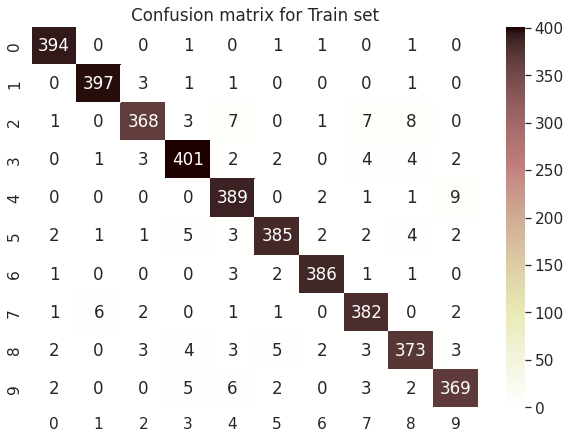

In [ ]:
CFN_Train = generate_confusion_matrix(NNet, df_MNIST_Train, 'Confusion matrix for Train set')

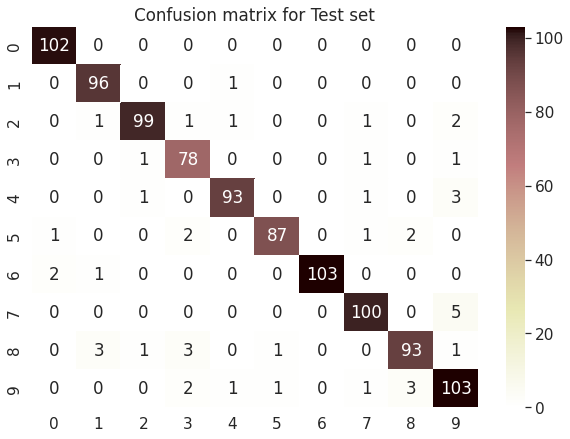

In [ ]:
CFN_Test = generate_confusion_matrix(NNet, df_MNIST_Test, 'Confusion matrix for Test set')